<a href="https://colab.research.google.com/github/Affanamin/MalwareDetection_InWindows/blob/master/Malware_Detection_In_Windows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing Libraries

#data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc

from sklearn import metrics
import lightgbm as lgb
#import xgboost as xgb
import time
import datetime
from numba import jit

import xgboost as xgb




In [0]:
#Data reading.
#from google.colab import files
#files.upload()


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#from google.colab import drive
#rive.mount('/content/drive')

In [0]:
#!pip install -q kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle
#!chmod 600 /root/.kaggle/kaggle.json  # set permission

In [0]:
#!kaggle competitions download -c microsoft-malware-prediction

In [0]:
#!mkdir malwareDetect

In [0]:
#!unzip -q train.csv.zip -d malwareDetect/  #unzip data in malwareDetect/

In [0]:
#!unzip -q test.csv.zip -d malwareDetect/  #unzip data in malwareDetect/

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', # was 'float32'
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', # was 'float16'
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [0]:
data_test = pd.read_csv('malwareDetect/test.csv',dtype=dtypes)

In [0]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7853253 entries, 0 to 7853252
Data columns (total 82 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            float32
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                         

In [0]:
data_train = pd.read_csv('malwareDetect/train.csv',dtype=dtypes)

In [0]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 83 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            float32
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                         

In [0]:
data_train.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,8.921483e+06,8889165.0,8.921483e+06,433438.000000,8.885262e+06,8885262.0,8885262.0,8.921483e+06,8.921483e+06,8.596074e+06,6169965.0,8921270.0,8.921483e+06,8.921483e+06,8.921483e+06,8885439.0,8.921483e+06,8.383724e+06,8862589.0,8830133.0,8.910645e+06,8.826005e+06,8.819250e+06,8880177.0,8880170.0,8.880140e+06,8.868467e+06,8.868481e+06,8.921483e+06,8.840950e+06,8.874349e+06,8.874497e+06,8.874497e+06,8.652728e+06,8.921483e+06,8.921483e+06,8861399.0,8.921483e+06,8.921483e+06,1.512724e+06,8.760960e+06,3.254158e+06,8738226.0,8.761350e+06,8.921483e+06,3.261780e+06,8.905530e+06,8.921483e+06,8.921483e+06,8850140.0,8618032.0,8618032.0,8.921483e+06
mean,7.509962e-06,NaN,1.733378e-02,1658.903809,4.948320e+04,NaN,NaN,9.879711e-01,1.080490e+02,8.049152e+04,NaN,NaN,1.228161e+02,1.571997e+04,5.751534e+02,NaN,2.891896e-05,4.649162e-04,NaN,NaN,1.302773e+01,2.219056e+03,2.378578e+05,NaN,NaN,2.327470e+03,3.089053e+06,3.773683e+05,7.718728e-02,6.109390e+03,1.694262e+01,1.522598e+03,9.542983e+02,1.123782e+09,1.583483e+04,9.730490e+02,NaN,6.046534e+01,5.452008e-04,1.388788e-05,1.007318e-05,2.508163e-04,NaN,3.268055e+04,4.860229e-01,2.980232e-07,7.202148e-03,1.255431e-01,3.807091e-02,NaN,NaN,NaN,4.997927e-01
std,2.740421e-03,0.0,1.305118e-01,999.028870,1.379994e+04,0.0,0.0,1.090149e-01,6.304706e+01,4.873461e+04,0.0,NaN,6.932125e+01,2.190685e+03,2.480847e+02,0.0,5.377558e-03,2.104187e-02,NaN,0.0,9.867770e+03,1.323710e+03,7.148446e+04,0.0,0.0,8.296290e+02,4.451634e+09,3.258791e+05,2.668884e-01,4.971148e+03,5.864020e+00,3.553196e+02,2.162140e+02,1.887782e+09,1.961743e+03,2.931971e+03,0.0,4.499992e+01,2.334317e-02,3.726959e-03,3.173828e-03,1.582336e-02,NaN,2.112612e+04,4.998046e-01,5.459785e-04,8.453369e-02,3.313338e-01,1.913675e-01,0.0,0.0,0.0,5.000000e-01
min,0.000000e+00,0.0,0.000000e+00,1.000000,3.000000e+00,0.0,0.0,0.000000e+00,1.000000e+00,5.000000e+00,1.0,1.0,1.000000e+00,7.600000e+03,1.600000e+01,0.0,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,7.000000e-01,-1.000000e+00,-1.000000e+00,0.000000e+00,7.600000e+03,0.000000e+00,1.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.000000e+00
25%,0.000000e+00,7.0,0.000000e+00,788.000000,4.948000e+04,1.0,1.0,1.000000e+00,5.100000e+01,3.682500e+04,18.0,89.0,7.400000e+01,1.506300e+04,2.560000e+02,1.0,0.000000e+00,0.000000e+00,111.0,1.0,1.000000e+00,1.443000e+03,1.896920e+05,2.0,5.0,1.998000e+03,2.393720e+05,1.207750e+05,0.000000e+00,4.096000e+03,1.390000e+01,1.366000e+03,7.680000e+02,0.000000e+00,1.506300e+04,1.670000e+02,8.0,3.100000e+01,0.000000e

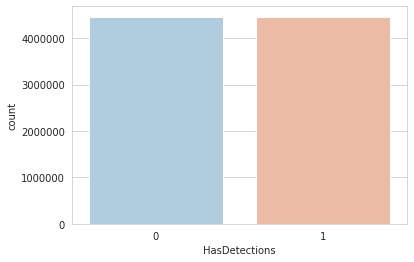

In [0]:
# Good Practice: Always check if data set is balance or imbalance.
sns.set_style('whitegrid')
sns.countplot(x='HasDetections',data=data_train,palette='RdBu_r')

In [0]:
statistics_of_data = []
for col in data_train.columns:
  statistics_of_data.append((col,
                             data_train[col].nunique(),
                             data_train[col].isnull().sum()*100/data_train.shape[0],
                             data_train[col].value_counts(normalize=True, dropna=False).values[0] * 100, 
                             data_train[col].dtype
                             ))
stats_df = pd.DataFrame(statistics_of_data, columns=['Feature', 'Uni_val', 'mis_val', 'val_biggest_cat', 'type'])



In [0]:
stats_df.sort_values('mis_val', ascending=False)
#pd.set_option('display.max_rows', stats_df[['Feature']].shape[0]+1)
#print(stats_df[['Feature', 'Uni_val', 'mis_val', 'val_biggest_cat', 'type']])

,Feature,Uni_val,mis_val,val_biggest_cat,type
28,PuaMode,2,99.974119,99.974119,category
41,Census_ProcessorClass,3,99.589407,99.589407,category
8,DefaultBrowsersIdentifier,2017,95.141637,95.141637,float32
68,Census_IsFlightingInternal,2,83.044030,83.044030,float16
52,Census_InternalBatteryType,78,71.046809,71.046809,category
...,...,...,...,...,...
1,ProductName,6,0.000000,98.935569,category
45,Census_HasOpticalDiskDrive,2,0.000000,92.281272,int8
54,Census_OSVersion,469,0.000000,15.845202,category
55,Census_OSArchitecture,3,0.000000,90.858045,category


Some Important observations:
1. PuaMode with null value = 99.974119 %, Census_ProcessorClass with null value	99.589407 % , and DefaultBrowsersIdentifier = 95+ % should be removed.

2. In val_biggest_cat any column having more than 90 % should be dropped.

Lets do this first.

In [0]:
for col in data_train.columns:
    rate = data_train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        #data_train.drop(col)
        print(col)

ProductName
IsBeta
RtpStateBitfield
IsSxsPassiveMode
DefaultBrowsersIdentifier
AVProductsEnabled
HasTpm
Platform
Processor
OsVer
IsProtected
AutoSampleOptIn
PuaMode
SMode
Firewall
UacLuaenable
Census_DeviceFamily
Census_ProcessorClass
Census_HasOpticalDiskDrive
Census_OSArchitecture
Census_IsPortableOperatingSystem
Census_IsFlightsDisabled
Census_FlightRing
Census_IsVirtualDevice
Census_IsPenCapable
Census_IsAlwaysOnAlwaysConnectedCapable


In [0]:
combine = [data_train, data_test]
print("Before", data_train.shape, data_test.shape,combine[0].shape, combine[1].shape)

data_train = data_train.drop([
'ProductName',
'IsBeta',
'RtpStateBitfield',
'IsSxsPassiveMode',
'DefaultBrowsersIdentifier',
'AVProductsEnabled',
'HasTpm',
'Platform',
'Processor',
'OsVer',
'IsProtected',
'AutoSampleOptIn',
'PuaMode',
'SMode',
'Firewall',
'UacLuaenable',
'Census_DeviceFamily',
'Census_ProcessorClass',
'Census_HasOpticalDiskDrive',
'Census_OSArchitecture',
'Census_IsPortableOperatingSystem',
'Census_IsFlightsDisabled',
'Census_FlightRing',
'Census_IsVirtualDevice',
'Census_IsPenCapable',
'Census_IsAlwaysOnAlwaysConnectedCapable'
], axis=1)
data_test = data_test.drop([
'ProductName',
'IsBeta',
'RtpStateBitfield',
'IsSxsPassiveMode',
'DefaultBrowsersIdentifier',
'AVProductsEnabled',
'HasTpm',
'Platform',
'Processor',
'OsVer',
'IsProtected',
'AutoSampleOptIn',
'PuaMode',
'SMode',
'Firewall',
'UacLuaenable',
'Census_DeviceFamily',
'Census_ProcessorClass',
'Census_HasOpticalDiskDrive',
'Census_OSArchitecture',
'Census_IsPortableOperatingSystem',
'Census_IsFlightsDisabled',
'Census_FlightRing',
'Census_IsVirtualDevice',
'Census_IsPenCapable',
'Census_IsAlwaysOnAlwaysConnectedCapable'
], axis=1)
combine = [data_train, data_test]

print("After", data_train.shape, data_test.shape, combine[0].shape, combine[1].shape)

Before (8921483, 83) (7853253, 82) (8921483, 83) (7853253, 82)
After (8921483, 57) (7853253, 56) (8921483, 57) (7853253, 56)


In [0]:
data_train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2341.0,476940.0,HDD,299451.0,4096.0,Desktop,18.9,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2405.0,476940.0,HDD,102385.0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4909.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.5,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2273.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.5,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.0,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.17134.191,rs4_release,17134,191,Core,CORE,Update,8.0,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1


EDA Starts From here :::

In [0]:
def exploreCatgoricalFeatures(col,  by_touch=False):
  top_n=10
  top_n = top_n if data_train[col].nunique() > top_n else data_train[col].nunique()
  print(f"{col} has {data_train[col].nunique()} unique values and type: {data_train[col].dtype}.")
  print(data_train[col].value_counts(normalize=True, dropna=False).head())

In [0]:
exploreCatgoricalFeatures('Census_IsTouchEnabled', True)

Census_IsTouchEnabled has 2 unique values and type: int8.
0    0.874457
1    0.125543
Name: Census_IsTouchEnabled, dtype: float64


In [0]:


top_n =10
top_n = top_n if data_train['Census_IsTouchEnabled'].nunique() > top_n else data_train['Census_IsTouchEnabled'].nunique()

top_cat = list(data_train['Census_IsTouchEnabled'].value_counts(dropna=False).index[:top_n])
df0 = data_train.loc[(data_train['Census_IsTouchEnabled'].isin(top_cat)) & (data_train['HasDetections'] == 1), 'Census_IsTouchEnabled'].value_counts().head(10).sort_index()
df1 = data_train.loc[(data_train['Census_IsTouchEnabled'].isin(top_cat)) & (data_train['HasDetections'] == 0), 'Census_IsTouchEnabled'].value_counts().head(10).sort_index()
data = [go.Bar(x=df0.index, y=df0.values, name='Has Detections'),
        go.Bar(x=df1.index, y=df1.values, name='No Detections')]

layout = go.Layout(dict(title = f"Counts of {'Census_IsTouchEnabled'} by top-{top_n} categories",
                        xaxis = dict(title = 'Census_IsTouchEnabled',
                                     showgrid=False,
                                     zeroline=False,
                                     showline=False,),
                        yaxis = dict(title = 'Counts',
                                     showgrid=False,
                                     zeroline=False,
                                     showline=False,),
                        ),
                   legend=dict(orientation="v"), barmode='group')
py.iplot(dict(data=data, layout=layout))

Observation:

When touch is not enabled infected rate is higher comprably.

In [0]:
#EngineVersion
exploreCatgoricalFeatures('EngineVersion', True)

EngineVersion has 70 unique values and type: category.
1.1.15200.1    0.430990
1.1.15100.1    0.412030
1.1.15000.2    0.029728
1.1.14901.4    0.023809
1.1.14600.4    0.018000
Name: EngineVersion, dtype: float64


In [0]:
top_n =10
top_n = top_n if data_train['EngineVersion'].nunique() > top_n else data_train['EngineVersion'].nunique()

df = data_train.groupby(['EngineVersion']).agg({'HasDetections': ['count', 'mean']})
df = df.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()

data = [go.Bar(x=df.index, y=df['HasDetections']['count'].values, name='counts'),
        go.Scatter(x=df.index, y=df['HasDetections']['mean'], name='Detections rate', yaxis='y2')]

layout = go.Layout(dict(title = f"Counts of {'EngineVersion'} by top-{top_n} categories and mean target value",
                        xaxis = dict(title = 'EngineVersion',
                                     showgrid=False,
                                     zeroline=False,
                                     showline=False,),
                        yaxis = dict(title = 'Counts',
                                     showgrid=False,
                                     zeroline=False,
                                     showline=False,),
                        yaxis2=dict(title='Detections rate', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
            
py.iplot(dict(data=data, layout=layout))

Observations later

In [0]:
def GraphPlotsForEDA(col, only_bars=False, top_n=10, by_touch=False):
    top_n = top_n if data_train[col].nunique() > top_n else data_train[col].nunique()
    #print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
    #print(train[col].value_counts(normalize=True, dropna=False).head())
    if not by_touch:
        if not only_bars:
            df = data_train.groupby([col]).agg({'HasDetections': ['count', 'mean']})
            df = df.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
            data = [go.Bar(x=df.index, y=df['HasDetections']['count'].values, name='counts'),
                    go.Scatter(x=df.index, y=df['HasDetections']['mean'], name='Detections rate', yaxis='y2')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories and mean target value",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis2=dict(title='Detections rate', overlaying='y', side='right')),
                           legend=dict(orientation="v"))

        else:
            top_cat = list(data_train[col].value_counts(dropna=False).index[:top_n])
            df0 = data_train.loc[(data_train[col].isin(top_cat)) & (data_train['HasDetections'] == 1), col].value_counts().head(10).sort_index()
            df1 = data_train.loc[(data_train[col].isin(top_cat)) & (data_train['HasDetections'] == 0), col].value_counts().head(10).sort_index()
            data = [go.Bar(x=df0.index, y=df0.values, name='Has Detections'),
                    go.Bar(x=df1.index, y=df1.values, name='No Detections')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                ),
                           legend=dict(orientation="v"), barmode='group')
        
        py.iplot(dict(data=data, layout=layout))
        
    else:
        top_n = 10
        top_cat = list(data_train[col].value_counts(dropna=False).index[:top_n])
        df = data_train.loc[data_train[col].isin(top_cat)]

        df1 = data_train.loc[data_train['Census_IsTouchEnabled'] == 1]
        df0 = data_train.loc[data_train['Census_IsTouchEnabled'] == 0]

        df0_ = df0.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df0_ = df0_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        df1_ = df1.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df1_ = df1_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        data1 = [go.Bar(x=df0_.index, y=df0_['HasDetections']['count'].values, name='Nontouch device counts'),
                go.Scatter(x=df0_.index, y=df0_['HasDetections']['mean'], name='Detections rate for nontouch devices', yaxis='y2')]
        data2 = [go.Bar(x=df1_.index, y=df1_['HasDetections']['count'].values, name='Touch device counts'),
                go.Scatter(x=df1_.index, y=df1_['HasDetections']['mean'], name='Detections rate for touch devices', yaxis='y2')]

        layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories for nontouch devices",
                            xaxis = dict(title = f'{col}',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,
                                         type='category'),
                            yaxis = dict(title = 'Counts',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,),
                                    yaxis2=dict(title='Detections rate', overlaying='y', side='right'),
                            ),
                       legend=dict(orientation="v"), barmode='group')

        py.iplot(dict(data=data1, layout=layout))
        layout['title'] = f"Counts of {col} by top-{top_n} categories for touch devices"
        py.iplot(dict(data=data2, layout=layout))

In [0]:
#EngineVersion
GraphPlotsForEDA('EngineVersion',by_touch = True)

In [0]:
#	Wdft_IsGamer
exploreCatgoricalFeatures('Wdft_IsGamer',True)

Wdft_IsGamer has 2 unique values and type: float16.
0.0    0.692053
1.0    0.273933
NaN    0.034014
Name: Wdft_IsGamer, dtype: float64


In [0]:

GraphPlotsForEDA('Wdft_IsGamer',by_touch = True)

In [0]:
#Census_IsSecureBootEnabled
#GraphPlotsForEDA('Census_IsSecureBootEnabled',by_touch = True)

In [0]:
#Census_OSEdition 
exploreCatgoricalFeatures('Census_OSEdition',True)

Census_OSEdition has 33 unique values and type: category.
Core                     0.388948
Professional             0.350902
CoreSingleLanguage       0.218065
CoreCountrySpecific      0.018618
ProfessionalEducation    0.006355
Name: Census_OSEdition, dtype: float64


In [0]:
GraphPlotsForEDA('Census_OSEdition',by_touch=True)

In [0]:
#Census_IsSecureBootEnabled 
exploreCatgoricalFeatures('Census_IsSecureBootEnabled',True)

Census_IsSecureBootEnabled has 2 unique values and type: int8.
0    0.513977
1    0.486023
Name: Census_IsSecureBootEnabled, dtype: float64


In [0]:
GraphPlotsForEDA('Census_IsSecureBootEnabled',by_touch=True)

In [0]:
exploreCatgoricalFeatures('Census_OSVersion', True)

Census_OSVersion has 469 unique values and type: category.
10.0.17134.228    0.158452
10.0.17134.165    0.100848
10.0.16299.431    0.061262
10.0.17134.285    0.052713
10.0.16299.547    0.038878
Name: Census_OSVersion, dtype: float64


In [0]:
exploreCatgoricalFeatures('Census_OSBranch',True)

Census_OSBranch has 32 unique values and type: category.
rs4_release               0.449382
rs3_release               0.138690
rs3_release_svc_escrow    0.134481
rs2_release               0.089342
rs1_release               0.088050
Name: Census_OSBranch, dtype: float64


In [0]:
exploreCatgoricalFeatures('Census_OSBuildNumber')

Census_OSBuildNumber has 165 unique values and type: int16.
17134    0.449351
16299    0.273861
15063    0.089340
14393    0.088040
10586    0.066528
Name: Census_OSBuildNumber, dtype: float64


In [0]:
GraphPlotsForEDA('Census_OSVersion',by_touch=True)

In [0]:

GraphPlotsForEDA('Census_OSBranch',by_touch=True)

In [0]:
#GraphPlotsForEDA('Census_OSBuildNumber',True)

In [0]:
data_train['Census_OSBuildNumber'] = data_train['Census_OSBuildNumber'].astype('category')
data_test['Census_OSBuildNumber'] = data_test['Census_OSBuildNumber'].astype('category')

In [0]:
data_train['Census_OSBuildRevision'] = data_train['Census_OSBuildRevision'].astype('category')
data_test['Census_OSBuildRevision'] = data_test['Census_OSBuildRevision'].astype('category')

In [0]:
GraphPlotsForEDA('Census_OSBuildRevision', by_touch=True)

In [0]:
#Census_FirmwareManufacturerIdentifier
exploreCatgoricalFeatures('Census_FirmwareManufacturerIdentifier',True)

Census_FirmwareManufacturerIdentifier has 712 unique values and type: float16.
142.0    0.302537
628.0    0.137773
554.0    0.131720
355.0    0.105565
556.0    0.089731
Name: Census_FirmwareManufacturerIdentifier, dtype: float64


In [0]:
GraphPlotsForEDA('Census_FirmwareManufacturerIdentifier', True)

In [0]:
#Census_ChassisTypeName
GraphPlotsForEDA('Census_ChassisTypeName', True, by_touch=True)

In [0]:
exploreCatgoricalFeatures('CountryIdentifier',True)

CountryIdentifier has 222 unique values and type: int16.
43     0.044519
29     0.039006
141    0.037372
93     0.031791
171    0.031449
Name: CountryIdentifier, dtype: float64


In [0]:
GraphPlotsForEDA('CountryIdentifier',True)

In [0]:
data_train['CountryIdentifier'] = data_train['CountryIdentifier'].astype('category')
data_test['CountryIdentifier'] = data_test['CountryIdentifier'].astype('category')

In [0]:
exploreCatgoricalFeatures('CityIdentifier',True)

CityIdentifier has 107366 unique values and type: float32.
NaN         0.036475
130775.0    0.010627
16668.0     0.009503
82373.0     0.009338
10222.0     0.008050
Name: CityIdentifier, dtype: float64


In [0]:
GraphPlotsForEDA('CityIdentifier', True,20)

In [0]:
data_train['CityIdentifier'] = data_train['CityIdentifier'].astype('category')
data_test['CityIdentifier'] = data_test['CityIdentifier'].astype('category')
#GeoNameIdentifier
#LocaleEnglishNameIdentifier
data_train['GeoNameIdentifier'] = data_train['GeoNameIdentifier'].astype('category')
data_test['GeoNameIdentifier'] = data_test['GeoNameIdentifier'].astype('category')
data_train['LocaleEnglishNameIdentifier'] = data_train['LocaleEnglishNameIdentifier'].astype('category')
data_test['LocaleEnglishNameIdentifier'] = data_test['LocaleEnglishNameIdentifier'].astype('category')

In [0]:
exploreCatgoricalFeatures('OrganizationIdentifier',True)

#GraphPlotsForEDA('OrganizationIdentifier', True)

OrganizationIdentifier has 49 unique values and type: float16.
27.0    0.470377
NaN     0.308415
18.0    0.197745
48.0    0.007156
50.0    0.005100
Name: OrganizationIdentifier, dtype: float64


In [0]:
GraphPlotsForEDA('OrganizationIdentifier', True,by_touch=True)

In [0]:
#OsPlatformSubRelease

exploreCatgoricalFeatures('OsPlatformSubRelease',True)

OsPlatformSubRelease has 9 unique values and type: category.
rs4    0.438887
rs3    0.280635
rs2    0.087460
rs1    0.081917
th2    0.046136
Name: OsPlatformSubRelease, dtype: float64


In [0]:
GraphPlotsForEDA('OsPlatformSubRelease', True,by_touch=True)

In [0]:
#OsBuildLab
exploreCatgoricalFeatures('OsBuildLab',True)

OsBuildLab has 663 unique values and type: category.
17134.1.amd64fre.rs4_release.180410-1804                 0.410044
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908    0.140411
16299.15.amd64fre.rs3_release.170928-1534                0.107724
15063.0.amd64fre.rs2_release.170317-1834                 0.080484
17134.1.x86fre.rs4_release.180410-1804                   0.028815
Name: OsBuildLab, dtype: float64


In [0]:
GraphPlotsForEDA('OsBuildLab', True,by_touch=True)

In [0]:
data_train['IeVerIdentifier'] = data_train['IeVerIdentifier'].astype('category')
data_test['IeVerIdentifier'] = data_test['IeVerIdentifier'].astype('category')
#
data_train['Census_OEMNameIdentifier'] = data_train['Census_OEMNameIdentifier'].astype('category')
data_test['Census_OEMNameIdentifier'] = data_test['Census_OEMNameIdentifier'].astype('category')
#
data_train['Census_OEMModelIdentifier'] = data_train['Census_OEMModelIdentifier'].astype('category')
data_test['Census_OEMModelIdentifier'] = data_test['Census_OEMModelIdentifier'].astype('category')
#
data_train['Census_ProcessorModelIdentifier'] = data_train['Census_ProcessorModelIdentifier'].astype('category')
data_test['Census_ProcessorModelIdentifier'] = data_test['Census_ProcessorModelIdentifier'].astype('category')
#
data_train['Census_InternalBatteryNumberOfCharges'] = data_train['Census_InternalBatteryNumberOfCharges'].astype('category')
data_test['Census_InternalBatteryNumberOfCharges'] = data_test['Census_InternalBatteryNumberOfCharges'].astype('category')
#


In [0]:
#
exploreCatgoricalFeatures('Census_ProcessorCoreCount',True)

#
#

#


Census_ProcessorCoreCount has 45 unique values and type: float16.
4.0     0.608665
2.0     0.259146
8.0     0.096957
12.0    0.010391
1.0     0.007890
Name: Census_ProcessorCoreCount, dtype: float64


In [0]:
GraphPlotsForEDA('Census_ProcessorCoreCount', True)

In [0]:
exploreCatgoricalFeatures('Census_TotalPhysicalRAM',True)

Census_TotalPhysicalRAM has 3446 unique values and type: float32.
4096.0     0.458950
8192.0     0.246204
2048.0     0.123015
16384.0    0.059582
6144.0     0.044687
Name: Census_TotalPhysicalRAM, dtype: float64


In [0]:
GraphPlotsForEDA('Census_TotalPhysicalRAM', True, by_touch=True)

In [0]:
#Census_InternalPrimaryDiagonalDisplaySizeInInches
exploreCatgoricalFeatures('Census_InternalPrimaryDiagonalDisplaySizeInInches',True)


Census_InternalPrimaryDiagonalDisplaySizeInInches has 785 unique values and type: float32.
15.5    0.341583
13.9    0.106717
14.0    0.060803
11.6    0.035799
21.5    0.030862
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: float64


In [0]:
GraphPlotsForEDA('Census_InternalPrimaryDiagonalDisplaySizeInInches', True,by_touch=True)

In [0]:
#Census_InternalBatteryNumberOfCharges
exploreCatgoricalFeatures('Census_InternalBatteryNumberOfCharges',True)



Census_InternalBatteryNumberOfCharges has 41088 unique values and type: category.
0.000000e+00    0.566431
4.294967e+09    0.252462
NaN             0.030124
1.000000e+00    0.006032
2.000000e+00    0.003153
Name: Census_InternalBatteryNumberOfCharges, dtype: float64


In [0]:
GraphPlotsForEDA('Census_InternalBatteryNumberOfCharges', True,by_touch=True)

In [0]:

exploreCatgoricalFeatures('Census_OSBranch',True)

GraphPlotsForEDA('Census_OSBranch', True,by_touch=True)



Census_OSBranch has 32 unique values and type: category.
rs4_release               0.449382
rs3_release               0.138690
rs3_release_svc_escrow    0.134481
rs2_release               0.089342
rs1_release               0.088050
Name: Census_OSBranch, dtype: float64


In [0]:
#Census_ChassisTypeName
exploreCatgoricalFeatures('Census_ChassisTypeName',True)

GraphPlotsForEDA('Census_ChassisTypeName', True,by_touch=True)

Census_ChassisTypeName has 52 unique values and type: category.
Notebook    0.588334
Desktop     0.209845
Laptop      0.076846
Portable    0.040453
AllinOne    0.022899
Name: Census_ChassisTypeName, dtype: float64


In [0]:
#Census_InternalBatteryType
exploreCatgoricalFeatures('Census_InternalBatteryType',True)

GraphPlotsForEDA('Census_InternalBatteryType', True)

Census_InternalBatteryType has 78 unique values and type: category.
NaN     0.710468
lion    0.227345
li-i    0.027531
#       0.020624
lip     0.006961
Name: Census_InternalBatteryType, dtype: float64


In [0]:
#Grouping Of Battery Types By name

def group_battery(x):
    x = x.lower()
    if 'li' in x:
        return 1
    else:
        return 0
data_train["Census_InternalBatteryType"] = data_train["Census_InternalBatteryType"].apply(group_battery)
data_train["Census_InternalBatteryType"] = data_train["Census_InternalBatteryType"].fillna(0)
data_test["Census_InternalBatteryType"] = data_test["Census_InternalBatteryType"].apply(group_battery)
data_test["Census_InternalBatteryType"] = data_test["Census_InternalBatteryType"].fillna(0)

In [0]:
exploreCatgoricalFeatures('Census_InternalBatteryType',True)

Census_InternalBatteryType has 2 unique values and type: float64.
0.0    0.732778
1.0    0.267222
Name: Census_InternalBatteryType, dtype: float64


In [0]:
#Grouping Of Census_OSEdition By Name:
exploreCatgoricalFeatures('Census_OSEdition',True)

Census_OSEdition has 33 unique values and type: category.
Core                     0.388948
Professional             0.350902
CoreSingleLanguage       0.218065
CoreCountrySpecific      0.018618
ProfessionalEducation    0.006355
Name: Census_OSEdition, dtype: float64


In [0]:
def rename_edition(x):
    x = x.lower()
    if 'core' in x:
        return 'Core'
    elif 'pro' in x:
        return 'pro'
    elif 'enterprise' in x:
        return 'Enterprise'
    elif 'server' in x:
        return 'Server'
    elif 'home' in x:
        return 'Home'
    elif 'education' in x:
        return 'Education'
    elif 'cloud' in x:
        return 'Cloud'
    else:
        return x

In [0]:
data_train['Census_OSEdition'] = data_train['Census_OSEdition'].astype(str)
data_test['Census_OSEdition'] = data_test['Census_OSEdition'].astype(str)
data_train['Census_OSEdition'] = data_train['Census_OSEdition'].apply(rename_edition)
data_test['Census_OSEdition'] = data_test['Census_OSEdition'].apply(rename_edition)
data_train['Census_OSEdition'] = data_train['Census_OSEdition'].astype('category')
data_test['Census_OSEdition'] = data_test['Census_OSEdition'].astype('category')

In [0]:
exploreCatgoricalFeatures('Census_OSEdition',True)

Census_OSEdition has 8 unique values and type: category.
Core          0.626167
pro           0.360472
Enterprise    0.006373
Education     0.004667
Server        0.001615
Name: Census_OSEdition, dtype: float64


In [0]:
GraphPlotsForEDA('Census_OSEdition',True,by_touch=True)

In [0]:
##Grouping Of Census_OSSkuName By Name: 
exploreCatgoricalFeatures('Census_OSSkuName',True)

Census_OSSkuName has 30 unique values and type: category.
CORE                    0.388934
PROFESSIONAL            0.357330
CORE_SINGLELANGUAGE     0.218028
CORE_COUNTRYSPECIFIC    0.018594
EDUCATION               0.004576
Name: Census_OSSkuName, dtype: float64


In [0]:
data_train['Census_OSSkuName'] = data_train['Census_OSSkuName'].astype(str)
data_test['Census_OSSkuName'] = data_test['Census_OSSkuName'].astype(str)
data_train['Census_OSSkuName'] = data_train['Census_OSSkuName'].apply(rename_edition)
data_test['Census_OSSkuName'] = data_test['Census_OSSkuName'].apply(rename_edition)
data_train['Census_OSSkuName'] = data_train['Census_OSSkuName'].astype('category')
data_test['Census_OSSkuName'] = data_test['Census_OSSkuName'].astype('category')

In [0]:
exploreCatgoricalFeatures('Census_OSSkuName',True)

Census_OSSkuName has 10 unique values and type: category.
Core          0.626093
pro           0.360543
Enterprise    0.006374
Education     0.004680
Server        0.001616
Name: Census_OSSkuName, dtype: float64


In [0]:
GraphPlotsForEDA('Census_OSSkuName',True,by_touch=True)

In [0]:
data_train['Census_OSInstallLanguageIdentifier'] = data_train['Census_OSInstallLanguageIdentifier'].astype('category')
data_test['Census_OSInstallLanguageIdentifier'] = data_test['Census_OSInstallLanguageIdentifier'].astype('category')

data_train['Census_OSUILocaleIdentifier'] = data_train['Census_OSUILocaleIdentifier'].astype('category')
data_test['Census_OSUILocaleIdentifier'] = data_test['Census_OSUILocaleIdentifier'].astype('category')

In [0]:
#SkuEdition.
data_train['SkuEdition'].value_counts(dropna=False, normalize=True)

Home               0.618097
Pro                0.361393
Invalid            0.008749
Education          0.004561
Enterprise         0.003851
Enterprise LTSB    0.002320
Cloud              0.000626
Server             0.000402
Name: SkuEdition, dtype: float64

Home and Pro editions together give 97.9%+ of all values. Condidering that other categories are for Enterprise mostly, I combine them with Pro.

In [0]:
pd.crosstab(data_train['SkuEdition'],data_train['Census_OSEdition'],normalize='columns')

Census_OSEdition,Cloud,Core,Education,Enterprise,Home,Server,pro,ultimate
SkuEdition,,,,,,,,
Cloud,0.888429,7.160321e-07,0.000000,0.000000,0.000000,0.000000,9.328509e-07,0.0
Education,0.000000,1.521568e-05,0.966952,0.000000,0.000000,0.000000,1.085217e-04,0.0
Enterprise,0.000000,2.148096e-06,0.000024,0.603117,0.000000,0.000139,1.648037e-05,0.0
Enterprise LTSB,0.000000,5.370240e-07,0.000048,0.363763,0.000000,0.000000,4.975205e-06,0.0
Home,0.001751,9.860368e-01,0.003843,0.001706,0.166667,0.000416,1.780812e-03,0.0
Invalid,0.000000,8.670432e-03,0.000360,0.000000,0.166667,0.748525,5.849286e-03,1.0
Pro,0.109820,5.274113e-03,0.028773,0.031379,0.666667,0.002498,9.922390e-01,0.0
Server,0.000000,0.000000e+00,0.000000,0.000035,0.000000,0.248421,0.000000e+00,0.0


Feature Engineering Starts From Here::::::::

In [0]:
data_train.head(10)

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2341.0,476940.0,HDD,299451.0,4096.0,Desktop,18.900000,1440.0,900.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,pro,pro,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2405.0,476940.0,HDD,102385.0,4096.0,Notebook,13.900000,1366.0,768.0,Mobile,0.0,1.000000e+00,10.0.17134.1,rs4_release,17134,1,pro,pro,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4909.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,Core,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2273.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,0.0,4.294967e+09,10.0.17134.228,rs4_release,17134,228,pro,pro,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,1.0,0.000000e+00,10.0.17134.191,rs4_release,17134,191,Core,Core,Update,8.0,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1
5,000016191b897145d069102325cab760,1.1.15100.1,4.18.1807.18075,1.273.1094.0,53447.0,1.0,97,13598.0,27.0,126.0,124,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,RequireAdmin,Desktop,3799.0,340727.0,2.0,5.0,4324.0,114473.0,SSD,113671.0,8192.0,Desktop,21.500000,1920.0,1080.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,pro,pro,UUPUpgrade,18.0,72,FullAuto,IS_GENUINE,Retail,0.0,0.0,93.0,510

In [0]:
data_train['EngineVersion'].describe()

count         8921483
unique             70
top       1.1.15200.1
freq          3845067
Name: EngineVersion, dtype: object

In [0]:
data_train['OsBuildLab'] = data_train['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
data_train['OsBuildLab'] = data_train['OsBuildLab'].fillna('0.0.0.0.0-0')

In [0]:
data_train.head(10)

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2341.0,476940.0,HDD,299451.0,4096.0,Desktop,18.900000,1440.0,900.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,pro,pro,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2405.0,476940.0,HDD,102385.0,4096.0,Notebook,13.900000,1366.0,768.0,Mobile,0.0,1.000000e+00,10.0.17134.1,rs4_release,17134,1,pro,pro,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4909.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,Core,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2273.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,0.0,4.294967e+09,10.0.17134.228,rs4_release,17134,228,pro,pro,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,1.0,0.000000e+00,10.0.17134.191,rs4_release,17134,191,Core,Core,Update,8.0,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1
5,000016191b897145d069102325cab760,1.1.15100.1,4.18.1807.18075,1.273.1094.0,53447.0,1.0,97,13598.0,27.0,126.0,124,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,RequireAdmin,Desktop,3799.0,340727.0,2.0,5.0,4324.0,114473.0,SSD,113671.0,8192.0,Desktop,21.500000,1920.0,1080.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,pro,pro,UUPUpgrade,18.0,72,FullAuto,IS_GENUINE,Retail,0.0,0.0,93.0,510

In [0]:
data_train['OsBuildLab_0'] = data_train['OsBuildLab'].apply(lambda x: x.split('.')[0]).astype('category')
data_train['OsBuildLab_1'] = data_train['OsBuildLab'].apply(lambda x: x.split('.')[1]).astype('category')
data_train['OsBuildLab_2'] = data_train['OsBuildLab'].apply(lambda x: x.split('.')[2]).astype('category')
data_train['OsBuildLab_3'] = data_train['OsBuildLab'].apply(lambda x: x.split('.')[3]).astype('category')

In [0]:
data_train.head(10)

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,OsBuildLab_0,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2341.0,476940.0,HDD,299451.0,4096.0,Desktop,18.900000,1440.0,900.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,pro,pro,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0,17134,1,amd64fre,rs4_release
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2405.0,476940.0,HDD,102385.0,4096.0,Notebook,13.900000,1366.0,768.0,Mobile,0.0,1.000000e+00,10.0.17134.1,rs4_release,17134,1,pro,pro,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0,17134,1,amd64fre,rs4_release
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4909.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,Core,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0,17134,1,amd64fre,rs4_release
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2273.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,0.0,4.294967e+09,10.0.17134.228,rs4_release,17134,228,pro,pro,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1,17134,1,amd64fre,rs4_release
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,1.0,0.000000e+00,10.0.17134.191,rs4_release,17134,191,Core,Core,Update,8.0,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1,17134,1,amd64fre,rs4_release
5,000016191b897145d069102325cab760,1.1.15100.1,4.18.1807.18075,1.273.1094.0,53447.0,1.0,97,13598.0,27.0,126.0,124,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,RequireAdmin,Desktop,3799.0,340727.0,2.0,5.0,432

In [0]:
data_train['EngineVersion_2'] = data_train['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')
data_train['EngineVersion_3'] = data_train['EngineVersion'].apply(lambda x: x.split('.')[3]).astype('category')

data_train['AppVersion_1'] = data_train['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
data_train['AppVersion_2'] = data_train['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
data_train['AppVersion_3'] = data_train['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')


data_train['AvSigVersion_0'] = data_train['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
data_train['AvSigVersion_1'] = data_train['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
data_train['AvSigVersion_2'] = data_train['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')

#Census_OSVersion
data_train['Census_OSVersion_0'] = data_train['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
data_train['Census_OSVersion_1'] = data_train['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
data_train['Census_OSVersion_2'] = data_train['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
data_train['Census_OSVersion_3'] = data_train['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')

data_train['Census_IsFlightingInternal'] = data_train['Census_IsFlightingInternal'].fillna(1)
data_train['Census_ThresholdOptIn'] = data_train['Census_ThresholdOptIn'].fillna(1)
data_train['Census_IsWIMBootEnabled'] = data_train['Census_IsWIMBootEnabled'].fillna(1)
data_train['Wdft_IsGamer'] = data_train['Wdft_IsGamer'].fillna(0)

## -------------------------------  NEED TO DO ON TEST DATA AS WELL  -------------------------------######


In [0]:
data_train.describe()

,AVProductStatesIdentifier,AVProductsInstalled,OrganizationIdentifier,OsBuild,OsSuite,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryType,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,8.885262e+06,8885262.0,6169965.0,8.921483e+06,8.921483e+06,8880177.0,8880170.0,8.868467e+06,8.868481e+06,8.840950e+06,8.874349e+06,8.874497e+06,8.874497e+06,8.921483e+06,8921483.0,8921483.0,8738226.0,8.761350e+06,8.921483e+06,8921483.0,8.921483e+06,8921483.0,8618032.0,8.921483e+06
mean,4.948320e+04,NaN,NaN,1.571997e+04,5.751534e+02,NaN,NaN,3.089053e+06,3.773683e+05,6.109390e+03,1.694262e+01,1.522598e+03,9.542983e+02,2.672223e-01,NaN,NaN,NaN,3.268055e+04,4.860229e-01,NaN,1.255431e-01,NaN,NaN,4.997927e-01
std,1.379994e+04,0.0,0.0,2.190685e+03,2.480847e+02,0.0,0.0,4.451634e+09,3.258791e+05,4.971148e+03,5.864020e+00,3.553196e+02,2.162140e+02,4.425094e-01,0.0,0.0,NaN,2.112612e+04,4.998046e-01,0.0,3.313338e-01,0.0,0.0,5.000000e-01
min,3.000000e+00,0.0,1.0,7.600000e+03,1.600000e+01,1.0,1.0,0.000000e+00,0.000000e+00,2.550000e+02,7.000000e-01,-1.000000e+00,-1.000000e+00,0.000000e+00,0.0,0.0,2.0,3.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,1.0,0.000000e+00
25%,4.948000e+04,1.0,18.0,1.506300e+04,2.560000e+02,2.0,5.0,2.393720e+05,1.207750e+05,4.096000e+03,1.390000e+01,1.366000e+03,7.680000e+02,0.000000e+00,1.0,0.0,142.0,1.315600e+04,0.000000e+00,0.0,0.000000e+00,0.0,3.0,0.000000e+00
50%,5.344700e+04,1.0,27.0,1.629900e+04,7.680000e+02,4.0,5.0,4.769400e+05,2.495000e+05,4.096000e+03,1.550000e+01,1.366000e+03,7.680000e+02,0.000000e+00,1.0,1.0,500.0,3.307000e+04,0.000000e+00,1.0,0.000000e+00,0.0,10.0,0.000000e+00
75%,5.344700e+04,2.0,27.0,1.713400e+04,7.680000e+02,4.0,5.0,9.538690e+05,4.759730e+05,8.192000e+03,1.720000e+01,1.920000e+03,1.080000e+03,1.000000e+00,1.0,1.0,556.0,5.243600e+04,1.000000e+00,1.0,0.000000e+00,1.0,11.0,1.000000e+00
max,7.050700e+04,7.0,52.0,1.824400e+04,7.840000e+02,192.0,10.0,8.160437e+12,4.768710e+07,1.572864e+06,1.823000e+02,1.228800e+04,8.640000e+03,1.000000e+00,1.0,1.0,1092.0,7.210500e+04,1.000000e+00,1.0,1.000000e+00,1.0,15.0,1.000000e+00


In [0]:
data_train['non_primary_drive_MB'] = data_train['Census_PrimaryDiskTotalCapacity'] - data_train['Census_SystemVolumeTotalCapacity']
data_train['aspect_ratio'] = data_train['Census_InternalPrimaryDisplayResolutionHorizontal']/ data_train['Census_InternalPrimaryDisplayResolutionVertical']
data_train['MegaPixels'] = (data_train['Census_InternalPrimaryDisplayResolutionHorizontal'] * data_train['Census_InternalPrimaryDisplayResolutionVertical'])/1e6
data_train['Screen_Area'] = (data_train['aspect_ratio']* (data_train['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(data_train['aspect_ratio']**2 + 1)
data_train['ram_per_processor'] = data_train['Census_TotalPhysicalRAM']/ data_train['Census_ProcessorCoreCount']

In [0]:
data_train.shape

(8921483, 78)

In [0]:
data_train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,OsBuildLab_0,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,EngineVersion_2,EngineVersion_3,AppVersion_1,AppVersion_2,AppVersion_3,AvSigVersion_0,AvSigVersion_1,AvSigVersion_2,Census_OSVersion_0,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,non_primary_drive_MB,aspect_ratio,MegaPixels,Screen_Area,ram_per_processor
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2341.0,476940.0,HDD,299451.0,4096.0,Desktop,18.9,1440.0,900.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,pro,pro,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,1.0,1.0,628.0,36144.0,0,1.0,0,0.0,10.0,0,17134,1,amd64fre,rs4_release,15100,1,18,1807,18075,1,273,1735,10,0,17134,165,177489.0,1.600000,1.296000,160.543808,1024.0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2405.0,476940.0,HDD,102385.0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,0.0,1.000000e+00,10.0.17134.1,rs4_release,17134,1,pro,pro,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,1.0,1.0,628.0,57858.0,0,1.0,0,0.0,8.0,0,17134,1,amd64fre,rs4_release,14600,4,13,17134,1,1,263,48,10,0,17134,1,374555.0,1.778646,1.049088,82.537643,1024.0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4909.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.5,1920.0,1080.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,Core,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,1.0,1.0,142.0,52682.0,0,1.0,0,0.0,3.0,0,17134,1,amd64fre,rs4_release,15100,1,18,1807,18075,1,273,1341,10,0,17134,165,566.0,1.777778,2.073600,197.519287,1024.0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2273.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.5,1366.0,768.0,Desktop,0.0,4.294967e+09,10.0.17134.228,rs4_release,17134,228,pro,pro,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,1.0,1.0,355.0,20050.0,0,1.0,0,0.0,3.0,1,17134,1,amd64fre,rs4_release,15100,1,18,1807,18075,1,273,1527,10,0,17134,228,11359.0,1.778646,1.049088,146.206253,1024.0
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37

In [0]:
#stats_df.sort_values('mis_val', ascending=False)
stats_df.head(60)

,Feature,Uni_val,mis_val,val_biggest_cat,type
0,MachineIdentifier,8921483,0.000000,0.000011,category
1,ProductName,6,0.000000,98.935569,category
2,EngineVersion,70,0.000000,43.098967,category
3,AppVersion,110,0.000000,57.605042,category
4,AvSigVersion,8531,0.000000,1.146861,category
5,IsBeta,2,0.000000,99.999249,int8
6,RtpStateBitfield,7,0.362249,96.973642,float16
7,IsSxsPassiveMode,2,0.000000,98.266622,int8
8,DefaultBrowsersIdentifier,2017,95.141637,95.141637,float32
9,AVProductStatesIdentifier,28970,0.405998,65.286960,float32


In [0]:
stats_df.tail(20)

,Feature,Uni_val,mis_val,val_biggest_cat,type
63,Census_OSUILocaleIdentifier,147,0.000000,35.541445,int16
64,Census_OSWUAutoUpdateOptionsName,6,0.000000,44.325557,category
65,Census_IsPortableOperatingSystem,2,0.000000,99.945480,int8
66,Census_GenuineStateName,5,0.000000,88.299187,category
67,Census_ActivationChannel,6,0.000000,52.991067,category
68,Census_IsFlightingInternal,2,83.044030,83.044030,float16
69,Census_IsFlightsDisabled,2,1.799286,98.199728,float16
70,Census_FlightRing,10,0.000000,93.657960,category
71,Census_ThresholdOptIn,2,63.524472,63.524472,float16
72,Census_FirmwareManufacturerIdentifier,712,2.054109,30.253692,float16


Frequency encoding
For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [0]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

binary_variables = [c for c in data_train.columns if data_train[c].nunique() == 2]

categorical_columns = [c for c in data_train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [0]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier'
    #'DefaultBrowsersIdentifier'
    
]

In [0]:
from tqdm import tqdm
from tqdm import tqdm_notebook
#from sklearn.preprocessing import LabelEncoder
def frequency_encoding(variable):
    t = pd.concat([data_train[variable], data_test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [0]:
for variable in tqdm(frequency_encoded_variables):
  freq_enc_dict = frequency_encoding(variable)
  data_train[variable] = data_train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
  #data_test[variable] = data_test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
  categorical_columns.remove(variable)

100%|██████████| 6/6 [00:09<00:00,  1.21s/it]


In [0]:
#indexer = {}
#for col in tqdm(categorical_columns):
    #if col == 'MachineIdentifier': continue
    #_, indexer[col] = pd.factorize(data_train[col])
    
#for col in tqdm(categorical_columns):
    #if col == 'MachineIdentifier': continue
    #data_train[col] = indexer[col].get_indexer(data_train[col])
    #data_test[col] = indexer[col].get_indexer(data_test[col])

In [0]:
#data_train = reduce_mem_usage(data_train)

In [0]:
#data_train.head()

In [0]:
data_test['OsBuildLab'] = data_test['OsBuildLab'].astype('category')
data_test['OsBuildLab'] = data_test['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
data_test['OsBuildLab'] = data_test['OsBuildLab'].fillna('0.0.0.0.0-0')


In [0]:
data_test['OsBuildLab_0'] = data_test['OsBuildLab'].apply(lambda x: x.split('.')[0]).astype('category')
data_test['OsBuildLab_1'] = data_test['OsBuildLab'].apply(lambda x: x.split('.')[1]).astype('category')
data_test['OsBuildLab_2'] = data_test['OsBuildLab'].apply(lambda x: x.split('.')[2]).astype('category')
data_test['OsBuildLab_3'] = data_test['OsBuildLab'].apply(lambda x: x.split('.')[3]).astype('category')

In [0]:
data_test['EngineVersion'] = data_test['EngineVersion'].astype('category')
data_test['EngineVersion_2'] = data_test['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')
data_test['EngineVersion_3'] = data_test['EngineVersion'].apply(lambda x: x.split('.')[3]).astype('category')

In [0]:
data_test['AppVersion'] = data_test['AppVersion'].astype('category')
data_test['AppVersion_1'] = data_test['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
data_test['AppVersion_2'] = data_test['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
data_test['AppVersion_3'] = data_test['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')

In [0]:
data_test['AvSigVersion'] = data_test['AvSigVersion'].astype('category')
data_test['AvSigVersion_0'] = data_test['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
data_test['AvSigVersion_1'] = data_test['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
data_test['AvSigVersion_2'] = data_test['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')


In [0]:
#Census_OSVersion
data_test['Census_OSVersion'] = data_test['Census_OSVersion'].astype('category')
data_test['Census_OSVersion_0'] = data_test['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
data_test['Census_OSVersion_1'] = data_test['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
data_test['Census_OSVersion_2'] = data_test['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
data_test['Census_OSVersion_3'] = data_test['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')

In [0]:
data_test['Census_IsFlightingInternal'] = data_test['Census_IsFlightingInternal'].astype('category')
data_test['Census_IsFlightingInternal'] = data_test['Census_IsFlightingInternal'].fillna(1)
data_test['Census_ThresholdOptIn'] = data_test['Census_ThresholdOptIn'].fillna(1)
data_test['Census_IsWIMBootEnabled'] = data_test['Census_IsWIMBootEnabled'].fillna(1)
data_test['Wdft_IsGamer'] = data_test['Wdft_IsGamer'].fillna(0)

In [0]:
data_test['non_primary_drive_MB'] = data_test['Census_PrimaryDiskTotalCapacity'] - data_test['Census_SystemVolumeTotalCapacity']
data_test['aspect_ratio'] = data_test['Census_InternalPrimaryDisplayResolutionHorizontal']/ data_test['Census_InternalPrimaryDisplayResolutionVertical']
data_test['MegaPixels'] = (data_test['Census_InternalPrimaryDisplayResolutionHorizontal'] * data_test['Census_InternalPrimaryDisplayResolutionVertical'])/1e6
data_test['Screen_Area'] = (data_test['aspect_ratio']* (data_train['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(data_test['aspect_ratio']**2 + 1)
data_test['ram_per_processor'] = data_test['Census_TotalPhysicalRAM']/ data_test['Census_ProcessorCoreCount']

In [0]:
data_train.shape

(8921483, 78)

In [0]:
data_test.shape

(7853253, 77)

In [0]:
categorical_columns = [c for c in data_train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]
                       

In [0]:
for variable in tqdm(frequency_encoded_variables):
  freq_enc_dict = frequency_encoding(variable)
  #data_train[variable] = data_train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
  data_test[variable] = data_test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
  categorical_columns.remove(variable)

100%|██████████| 6/6 [00:08<00:00,  1.15s/it]


In [0]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(data_train[col])

100%|██████████| 54/54 [00:04<00:00, 11.84it/s]


In [0]:
#for col in tqdm(categorical_columns):
    #if col == 'MachineIdentifier': continue
    #data_train[col] = indexer[col].get_indexer(data_train[col])
    #data_test[col] = indexer[col].get_indexer(data_test[col])

In [0]:
data_train = reduce_mem_usage(data_train)

Mem. usage decreased to 1615.09 Mb (25.8% reduction)


In [0]:
data_test = reduce_mem_usage(data_test)

Mem. usage decreased to 1445.23 Mb (25.5% reduction)


In [0]:
data_train.head(10)

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,OsBuildLab_0,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,EngineVersion_2,EngineVersion_3,AppVersion_1,AppVersion_2,AppVersion_3,AvSigVersion_0,AvSigVersion_1,AvSigVersion_2,Census_OSVersion_0,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,non_primary_drive_MB,aspect_ratio,MegaPixels,Screen_Area,ram_per_processor
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,134.0,53447.0,1.0,29,205.0,18.0,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,0.0,22022.0,4.0,5.0,126.0,476940.0,HDD,299451.0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,pro,pro,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,1.0,1.0,628.0,2572.0,0,1.0,0,0.0,10.0,0,17134,1,amd64fre,rs4_release,15100,1,18,1807,18075,1,273,1735,10,0,17134,165,177489.0,1.599609,1.295898,160.5000,1024.0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,0.0,53447.0,1.0,93,171.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,0.0,118655.0,4.0,5.0,123.0,476940.0,HDD,102385.0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,0.0,1.000000e+00,10.0.17134.1,rs4_release,17134,1,pro,pro,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,1.0,1.0,628.0,1415.0,0,1.0,0,0.0,8.0,0,17134,1,amd64fre,rs4_release,14600,4,13,17134,1,1,263,48,10,0,17134,1,374555.0,1.778320,1.048828,82.5625,1024.0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,336.0,53447.0,1.0,86,673.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,10.0,2.0,4.0,5.0,187.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,0.0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,Core,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,1.0,1.0,142.0,184.0,0,1.0,0,0.0,3.0,0,17134,1,amd64fre,rs4_release,15100,1,18,1807,18075,1,273,1341,10,0,17134,165,566.0,1.777344,2.074219,197.5000,1024.0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,25.0,53447.0,1.0,88,20.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,2.0,158.0,4.0,5.0,57.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,0.0,4.294967e+09,10.0.17134.228,rs4_release,17134,228,pro,pro,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,1.0,1.0,355.0,30.0,0,1.0,0,0.0,3.0,1,17134,1,amd64fre,rs4_release,15100,1,18,1807,18075,1,273,1527,10,0,17134,228,11359.0,1.778320,1.048828,146.2500,1024.0
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,18.0,53447.0,1.0,18,13.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.18041

In [0]:
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    data_train[col] = indexer[col].get_indexer(data_train[col])
    #data_test[col] = indexer[col].get_indexer(data_test[col])

100%|██████████| 54/54 [14:58<00:00,  4.02s/it]


Data Modeling Starts from here :::

In [0]:
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    #data_train[col] = indexer[col].get_indexer(data_train[col])
    data_test[col] = indexer[col].get_indexer(data_test[col])



 54%|█████▎    | 29/54 [12:44<12:21, 29.65s/it]

In [0]:
data_train.shape

In [0]:
data_test.shape

In [0]:
train = data_train.copy()
test = data_test.copy()

In [0]:
#First check these copied dataframes.
train.shape

In [0]:
test.shape

In [0]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [0]:
train = train[:4000000]

In [0]:
target = train['HasDetections']
del train['HasDetections']

In [0]:
train = train.drop(["MachineIdentifier"],axis =1)

In [0]:
##_____________________________________________________----------------------------------------------------____________________________________________________

param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1}



In [0]:
max_iter = 5

In [0]:
gc.collect()

In [0]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)

In [0]:
#oof = np.zeros(len(train))
#categorical_columnss = [c for c in categorical_columns if c not in ['MachineIdentifier']]

In [0]:
features = [c for c in train.columns if c not in ['MachineIdentifier']]
predictions = np.zeros(len(test))

In [0]:
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()

In [0]:
score = [0 for _ in range(folds.n_splits)]

In [0]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns
                          )
    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 100000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break

if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))
    
